<a href="https://colab.research.google.com/github/WoradeeKongthong/stock_price_time_series/blob/master/14_stockPrice_univariate_CNN_LSTM_singleStepOutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN LSTM : time series forcasting with 1 feature input and 1 step output**

In [0]:
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Dataset : google stock price (2015-2019) from yahoo.com

In [0]:
df = DataReader('GOOG', data_source='yahoo', start='2015-01-01', end='2019-12-31')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680


In [0]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680
...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,1343.560059
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,1360.400024
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,1351.890015


#  Get X from Dataframe
Time series to train the model is the 'Close' price.  

In [0]:
data = df.loc[:, ['Close']].values

In [0]:
data.shape

(1258, 1)

# Data Preprocessing

In [0]:
# Feature Scaling on the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
data_scaled = sc.fit_transform(data)

In [0]:
# check the shape of preprocessed data
print(data_scaled.shape)
data_scaled

(1258, 1)


array([[0.03698029],
       [0.0244395 ],
       [0.01078684],
       ...,
       [0.98933292],
       [0.97122881],
       [0.97224035]])

# Create timestep sequence
X : n_steps sequence of data  
y : 1 step output

In [0]:
def create_sequence(data, n_steps):
  X = []
  y = []
  for i in range(n_steps, len(data)):
    X.append(data[i - n_steps:i])
    y.append(data[i])
  return np.array(X), np.array(y)

In [0]:
# choose number of timesteps, subsequence and features
n_steps = 60
n_subsequence = 6
n_substeps = int(n_steps/n_subsequence)
n_features = 1
# Create the sequence and the output
X,y = create_sequence(data_scaled, n_steps)
print('X shape : ',X.shape)
print('y shape : ',y.shape)

# reshape input for CNN-LSTM model : [samples, subsequence, timesteps of subsequence, features]
X = X.reshape((X.shape[0], n_subsequence, n_substeps, n_features))
print('After reshape')
print('X shape : ',X.shape)
print('y shape : ',y.shape)

X shape :  (1198, 60, 1)
y shape :  (1198, 1)
After reshape
X shape :  (1198, 6, 10, 1)
y shape :  (1198, 1)


In [0]:
print(X[0],'==>',y[0])

[[[0.03698029]
  [0.0244395 ]
  [0.01078684]
  [0.00980102]
  [0.01161222]
  [0.00414966]
  [0.        ]
  [0.00416113]
  [0.00953737]
  [0.01059198]]

 [[0.01780232]
  [0.01644967]
  [0.02921971]
  [0.04796196]
  [0.05433553]
  [0.04890201]
  [0.02989603]
  [0.02000327]
  [0.02075982]
  [0.04811105]]

 [[0.04118724]
  [0.04205846]
  [0.03463028]
  [0.04015557]
  [0.04407599]
  [0.04044216]
  [0.05088509]
  [0.04977316]
  [0.05775158]
  [0.06472121]]

 [[0.05764838]
  [0.05404893]
  [0.05768276]
  [0.05318922]
  [0.0451191 ]
  [0.04991074]
  [0.05882914]
  [0.07213788]
  [0.07548511]
  [0.09031852]]

 [[0.09295505]
  [0.09264552]
  [0.09489232]
  [0.08612869]
  [0.08746415]
  [0.07159914]
  [0.06720873]
  [0.07217225]
  [0.06278394]
  [0.07102595]]

 [[0.06681893]
  [0.07674606]
  [0.07501512]
  [0.07773192]
  [0.0759551 ]
  [0.08900025]
  [0.07592647]
  [0.07178253]
  [0.06395319]
  [0.06818308]]] ==> [0.06356339]


# CNN LSTM model
CNN layer 
  - extracting and learning features from subsequence of input  
  - need to be wrapped in TimeDistributed layer  
  
LSTM layer  
  - interpreting the features  

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten

Using TensorFlow backend.


In [0]:
# define the model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_substeps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 10, 64)      128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 5, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 320)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                74200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 74,379
Trainable params: 74,379
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [0]:
history = model.fit(X, y, epochs = 200, verbose = 0)

training loss :  0.03677880019921256


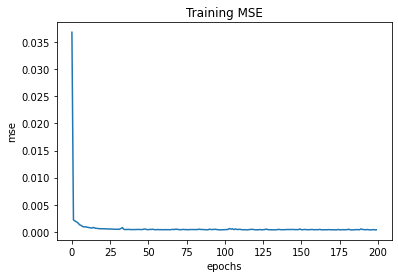

In [0]:
score = history.history['loss'][0]
print('training loss : ', score)

plt.plot(history.history['loss'])
plt.title('Training MSE')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.show()

Model Evaluation : 
MSE :  276.6601467087448
RMSE :  16.63310394089885


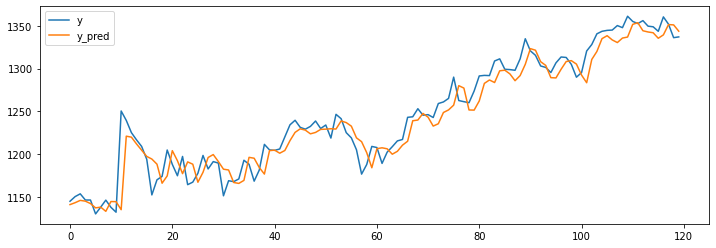

In [0]:
y_pred = model.predict(X)

# inverse transform the price
y = sc.inverse_transform(y.reshape(len(y),1))
y_pred = sc.inverse_transform(y_pred.reshape(len(y_pred),1))

# calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y, y_pred)
rmse = sqrt(mse)
print('Model Evaluation : ')
print('MSE : ', mse) 
print('RMSE : ', rmse)

# plot
plt.figure(figsize=(12,4))
plt.plot(y[-120:])
plt.plot(y_pred[-120:])
plt.legend(['y','y_pred'])
plt.show()

# Model Evaluation : walk forward validation

In [0]:
# get the test set : Jan - March of 2020
df = DataReader('GOOG', data_source='yahoo', start='2020-01-01', end='2020-03-31')
test = df.loc[:,['Close']].values

# feature scaling on the test set
test = sc.transform(test)

# seed the last n_steps in training dataset
history = data_scaled[-n_steps:]

# create timestep sequence for the training set
test = np.concatenate((history, test), axis=0)
X_test, y_test = create_sequence(test, n_steps)
X_test = X_test.reshape((X_test.shape[0], n_subsequence, n_substeps, n_features))

print('X_test shape : ',X_test.shape)
print('y_test shape : ',y_test.shape)

X_test shape :  (62, 6, 10, 1)
y_test shape :  (62, 1)


In [0]:
# Make predictions
y_pred = model.predict(X_test)

In [0]:
# inverse transform y_test and y_pred 
y_test = sc.inverse_transform(y_test)
y_pred = sc.inverse_transform(y_pred)

Model Evaluation : 
MSE :  2247.190031868799
RMSE :  47.404535984110204


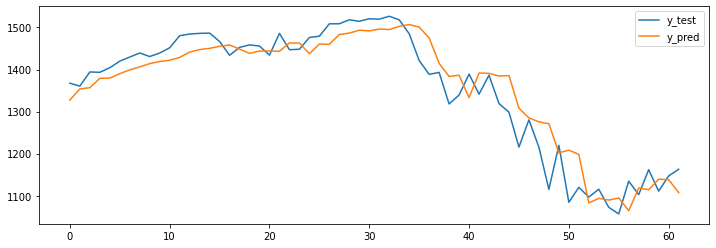

In [0]:
# calculate rmse
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('Model Evaluation : ')
print('MSE : ', mse) 
print('RMSE : ', rmse)

# plot
plt.figure(figsize=(12,4))
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['y_test','y_pred'])
plt.show()